In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix


# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/train', transform=transform)
validation_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/val', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/test', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=8)

#validation_set = validation_ds
validation_loader = T.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=8)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=8)

In [3]:
class NewNetwork(nn.Module):
    def __init__(self, num_classes=291):
        super(NewNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(36 * 16 * 16, 1000), #mettre 128 quand il y a 5 couches
            nn.PReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.PReLU(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [4]:
net = NewNetwork()
net.to(device)

NewNetwork(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=1000, bias=True)
    (2): PReLU(num_parameters=1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5)

In [5]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

test_acc = []

lrs = []
steps = []

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 201)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % 10 == 0: #ici changer pour la frequence d'affichage
        print('\nEpoch: {}'.format(epoch))
    #    print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the validation set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the validation set
    with T.no_grad():
        correct = 0
        total = 0
        validation_running_loss = .0
        for data in validation_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 200: # a changer si besoin d'afficher la matrice de confusion, a mettre à epoch-1
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        validation_running_loss /= len(validation_loader)
        validation_loss.append(validation_running_loss)
        validation_running_acc = correct / total
        validation_acc.append(validation_running_acc)
        
        if epoch % 10 == 0: #ici changer pour la frequence d'affichage
            print('validation Acc.  => {:.3f}%'.format(100 * validation_running_acc), end=' | ')
            print('validation Loss  => {:.5f}'.format(validation_running_loss))

    with torch.no_grad():
        correct_t = 0
        total_t = 0
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
            
            running_acc_t = correct_t / total_t
        test_acc.append(running_acc_t)
    
        if epoch % 10 == 0: #ici changer pour la frequence d'affichage
            print('Accuracy of the network on test images: %d %%' % (100 * correct_t / total_t))

print('Finished Training')

  0%|          | 0/201 [00:00<?, ?it/s]


Epoch: 0
Train Loss => 5.53733
validation Acc.  => 1.225% | validation Loss  => 5.46802
Accuracy of the network on test images: 1 %

Epoch: 10
Train Loss => 4.06155
validation Acc.  => 8.769% | validation Loss  => 4.06655
Accuracy of the network on test images: 9 %

Epoch: 20
Train Loss => 2.63917
validation Acc.  => 27.660% | validation Loss  => 2.80278
Accuracy of the network on test images: 28 %

Epoch: 30
Train Loss => 1.74150
validation Acc.  => 49.726% | validation Loss  => 1.82052
Accuracy of the network on test images: 49 %

Epoch: 40
Train Loss => 1.29697
validation Acc.  => 59.881% | validation Loss  => 1.39412
Accuracy of the network on test images: 59 %

Epoch: 50
Train Loss => 1.04196
validation Acc.  => 65.796% | validation Loss  => 1.18295
Accuracy of the network on test images: 65 %

Epoch: 60
Train Loss => 0.88552
validation Acc.  => 65.554% | validation Loss  => 1.14165
Accuracy of the network on test images: 65 %

Epoch: 70
Train Loss => 0.76762
validation Acc.  => 

## Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

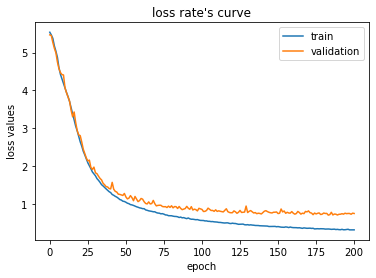

In [8]:
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

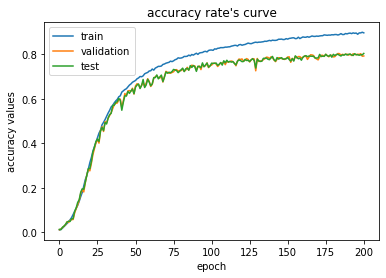

In [9]:
plt.plot(train_acc, label='train')
plt.plot(validation_acc, label='validation')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [10]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[ 3  4  0 ...  0  0  0]
 [ 1 39  0 ...  0  0  0]
 [ 0  0 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 18  0]
 [ 0  0  0 ...  0  0 28]]


<AxesSubplot:>

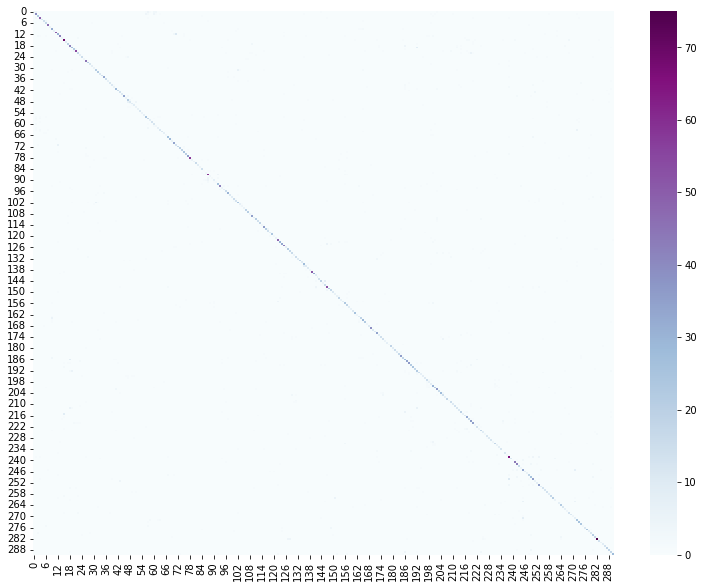

In [11]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [12]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 14.28571429  66.10169492  91.66666667  85.96491228  75.
  73.68421053  77.27272727  97.87234043 100.          84.21052632
  70.          98.03921569  65.95744681  75.          55.55555556
  80.23255814  90.90909091  76.92307692  79.24528302  61.36363636
  80.76923077  80.88235294  54.83870968  80.          62.5
  57.14285714  95.74468085 100.          85.71428571  88.88888889
  83.33333333  61.76470588  91.66666667 100.         100.
  91.66666667 100.          58.33333333  75.          61.11111111
  54.54545455  80.55555556  88.88888889  81.25        71.42857143
  85.          83.33333333  75.          47.82608696  75.
  81.81818182  62.5         75.         100.         100.
  63.63636364  75.75757576  72.          72.72727273  86.66666667
  70.58823529  60.          63.63636364  50.          78.57142857
  77.77777778  50.          76.47058824  87.87878788 100.
  97.14285714  65.          85.          83.33333333  90.47619048
  89.28571429  83.33333333  87.5         90.625       45.

## Save

In [13]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/dict_Linh_network_1st_try")

In [14]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/Linh_network_entire_model_1st_try")

In [15]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [16]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"